# Homework 4

In [ ]:
library(tidyverse)
library(DBI)
library(RSQLite)

## Task 1: Joining Data

We begin by joining the data of cellphones from the previous homework with the new data of population sizes. First we need to deal with the missing values (same as last homework).

In [2]:
df_prep_untidy <- read.csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")


# Removing data for years prior 2000 
df_prep_2000 <- select(df_prep_untidy,-2:-37) 


# Changing empty strings to NA's for locf and locb
df_with_na <- mutate(df_prep_2000,across(everything(), ~ na_if(., "")))


# Removing id row for countries
column_1_prep <- df_with_na[, 1, drop = FALSE]

# Filling in missing data with locf & locb, binding id column and filled data frame
df_filled <- as.data.frame(
  cbind(
    column_1_prep,  # Add the id row back for countries to the locf + locb data frame
    t(apply(df_with_na[, -1], 1, function(row) zoo::na.locf(zoo::na.locf(row, na.rm = FALSE), fromLast = TRUE)))
  )
)

      
# Function for converting strings like "2.6k" to a real number
convert_to_numeric <- function(x) {
  if (str_detect(x, "k")) {
    return(as.numeric(str_remove(x, "k")) * 1e3)
  } else if (str_detect(x, "M")) {
    return(as.numeric(str_remove(x, "M")) * 1e6)
  } else if (str_detect(x, "B")) {
    return(as.numeric(str_remove(x, "B")) * 1e9)
  } else {
    # If no suffix, just return the numeric value
    return(as.numeric(x))
  }
}


# Convert strings to numbers
df_cph <- df_filled |>
  mutate(across(
    .cols = -1,  
    .fns = ~sapply(., convert_to_numeric)
  ))

In the proces of dealing with missing values in the last lab, some years were removed. To make our new population data frame compatible with the prior we remove these years as well (so the years of the two data frames match). We also deal with the missing values in our data frame. In the data frame for populations sizes the missing values are written with NAs.

In [3]:
df_pop_untidy <- read.csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")


# Removing years to make the years of our two data frames match
df_pop_2000 <- select(df_pop_untidy,-3:-41) 
df_pop_2000 <- select(df_pop_2000,-last_col())[,-1]
df_pop_2000 <- mutate(df_pop_2000,across(everything(), as.character))


# Removing countries with only missing values (locf + locb wouldn't work)
df_pop_2000 <- filter(df_pop_2000,rowSums(df_pop_2000 == "") < 20)


# Removing id row for country
column_1_pop <- df_pop_2000[, 1, drop = FALSE]


# Applying locf to population data frame
df_pop_forw <- t(apply(df_pop_2000[, -1], 1, function(row) zoo::na.locf(row, na.rm = FALSE)))


# Applying locb to population data frame 
df_pop_back <- t(apply(df_pop_forw[, -1], 1, function(row) zoo::na.locf(row, na.rm = FALSE, fromLast=TRUE)))


# Binding filled data and id & converting years as strings to years as numerical
df_pop <- as.data.frame(cbind(column_1_pop,df_pop_back))
                       
df_pop <- df_pop |>
  mutate(across(
    .cols = -1,  
    .fns = ~sapply(., convert_to_numeric)
  ))

We now have a filled data frame for population sizes and for cellphone numbers (for years from 2000 to 2019).
However our data frames need not contain the same countries (they don't). So we filter out those countries only found in one of the data frames and not in the other:

In [4]:
df_pop <- df_pop |>
  filter(iso.3 %in% df_cph$iso.3)

df_cph <- df_cph |>
  filter(iso.3 %in% df_pop$iso.3)

We now join our two data frames together (note that instead of manually removing countries not shared in our
two data frames we could instead have used inner_join when joining them).

In [ ]:
df_pop_long <- pivot_longer(df_pop,cols = X2000:X2019,names_to = "Year", values_to = "Population")
df_cph_long <- pivot_longer(df_cph,cols = X2000:X2019,names_to = "Year", values_to = "Number_of_cellphones")
df_pop_cph <- full_join(df_pop_long,df_cph_long)

We now present a table similar to the one found homework instructions. I changed the year from 1960 to 2000 since my data starts at 2000 and not 1960. Otherwise I kept the countries the same. 

In [6]:
for_table <- filter(df_pop_cph, iso.3 %in% c("ABW","AFG","AGO","ALB","AND") & Year == "X2000")
for_table

iso.3,Year,Population,Number_of_cellphones
<chr>,<chr>,<dbl>,<dbl>
ABW,X2000,89101,15000
AFG,X2000,19542982,0
AGO,X2000,16394062,25800
ALB,X2000,3089027,29800
AND,X2000,66097,23500


We now combine the three data frames (cellphones, population and country names) and change the names of the countries from just three letters to their full names.

In [7]:
df_country <- read.csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")


country_names <- df_country |>
    select(alpha.3,name)


df_combined <- df_pop_cph |>
    left_join(country_names, by = c("iso.3" = "alpha.3")) |>
    select(-iso.3) |>
    relocate(name, .before = Year)

We also calculate the number of cellphones per capita and add it as a new variable in our dataframe.

In [8]:
df_combined <- mutate(df_combined, cellphones_per_capita = Number_of_cellphones / Population )

We give a table similar to the one found in the homework instructions:

In [9]:
df_combined|>
filter(name %in% c("Macao","Hong Kong","United Arab Emirates","Antigua and Barbuda","Seychelles"))|>
filter(Year %in% c("X2015","X2016","X2017","X2018","X2019"))|>
select(name,Year, cellphones_per_capita)|>
pivot_wider(names_from = name, values_from = cellphones_per_capita)

Year,United Arab Emirates,Antigua and Barbuda,Hong Kong,Macao,Seychelles
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X2015,2.007424,1.956838,2.290401,3.088231,1.584260
X2016,2.212521,1.987545,2.398931,3.143510,1.605459
X2017,2.183431,2.019337,2.488773,3.210102,1.742433
X2018,2.199084,2.008164,2.670209,3.348741,1.849900
X2019,2.127739,1.997460,2.863650,3.284849,1.987196


Lastly we analyse which country has the largest growth in number of cellphones per capita during the last 10 years. Since my data ends at year 2019, this means that we plot the growth rate of the countries in the table above for years 2010 through 2019.

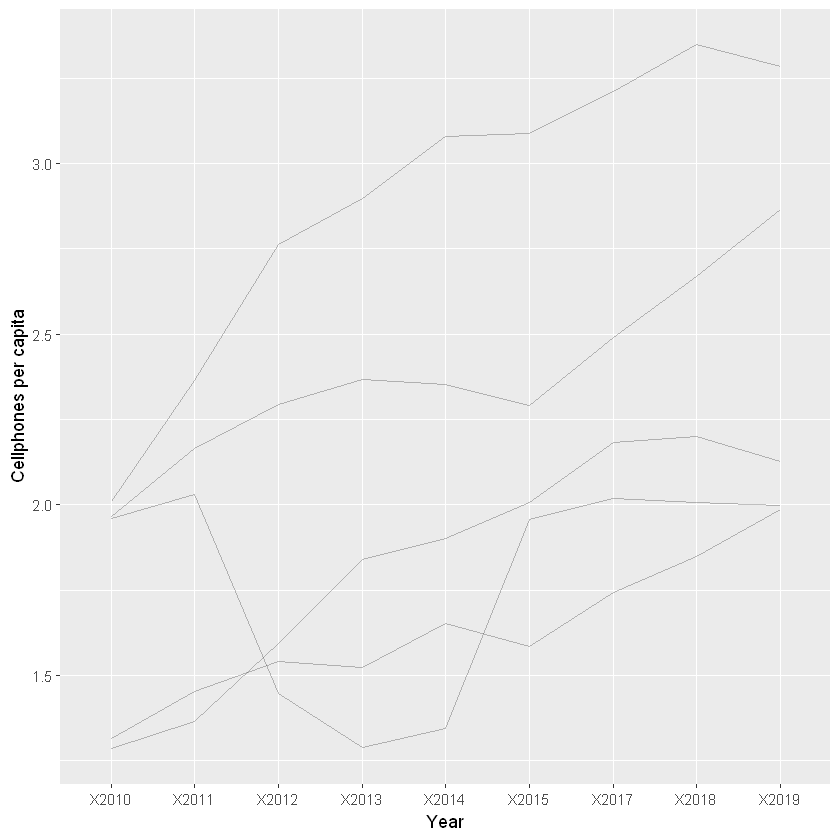

In [10]:
df_combined|>
filter(Year %in% c("X2010","X2011","X2012","X2013","X2014","X2015","X20016"
                   ,"X2017","X2018","X2019"))|>
filter(name %in% c("Macao","Hong Kong","United Arab Emirates","Antigua and Barbuda","Seychelles"))|>
ggplot(aes(x=Year,y= cellphones_per_capita, group = name))+
geom_line(alpha=0.25)+
labs(x="Year",y="Cellphones per capita")

It seems like Macao is the country that has had the largest growth rate in cellphones per capita in the last decade.

# Task 2: SQL

In [11]:
db_path <- "C:\\Users\\elisr\\Downloads\\user_actions.db"
con <- dbConnect(RSQLite::SQLite(), dbname = db_path)
tables <- dbListTables(con)

We find all (unique) usernames who have performed the "signup" action and print them. 

In [12]:
query <- "
  SELECT DISTINCT username 
  FROM user_actions 
  WHERE action = 'signup';
"


signup_users <- dbGetQuery(con, query)
print(signup_users)

   username
1    user34
2    user28
3     user1
4    user24
5    user15
6    user20
7    user18
8    user25
9     user3
10    user9
11   user27
12   user16
13   user17
14    user4
15    user8
16   user13
17   user19
18   user31
19   user10
20   user23
21   user11
22   user33
23   user12
24   user29
25   user21
26    user6
27   user14
28   user30
29    user7
30   user26
31   user22
32    user5
33   user35
34    user2
35   user32


We find the total number of log entries for each user and display it together with their username and user_id. 

In [13]:
query <- "
  SELECT 
    user_id, 
    username, 
    COUNT(*) AS log_count
  FROM 
    user_actions
  GROUP BY 
    user_id, username 
"


user_log_counts <- dbGetQuery(con, query)
print(user_log_counts)

   user_id username log_count
1        1    user1       104
2        2    user2       149
3        3    user3       108
4        4    user4       436
5        5    user5       192
6        6    user6       457
7        7    user7       362
8        8    user8       329
9        9    user9       118
10      10   user10       170
11      11   user11       328
12      12   user12       209
13      13   user13       470
14      14   user14       320
15      15   user15        35
16      16   user16       379
17      17   user17       367
18      18   user18       122
19      19   user19        58
20      20   user20       362
21      21   user21       323
22      22   user22       275
23      23   user23       309
24      24   user24       162
25      25   user25       136
26      26   user26       217
27      27   user27       211
28      28   user28        91
29      29   user29        49
30      30   user30       165
31      31   user31       389
32      32   user32        32
33      33

We find all users who have both logged in (as in action = 'login') and signed up (as in action = 'signup') on the same day. We then display the username and user_id for these people. 

In [14]:
query <- "
  SELECT DISTINCT
    a.user_id,
    a.username
  FROM
    user_actions AS a
  JOIN
    user_actions AS b
  ON
    a.user_id = b.user_id
    AND a.action = 'signup'
    AND b.action = 'login'
    AND DATE(a.timestamp) = DATE(b.timestamp);
"


users_with_both_actions <- dbGetQuery(con, query)
print(users_with_both_actions)

  user_id username
1       8    user8
2      12   user12
3      30   user30
4       7    user7
5      22   user22
6       5    user5
7       2    user2
8      32   user32


# Task 3: Regex

In [ ]:
lines <- readLines("C:\\Users\\elisr\\Downloads\\comments.txt")
lines

We begin by writing a regular expression to extract all hashtags from a given comment. For ease of use
I decided to bake it into a function. 

In [16]:
finding_hashtags <- function(comment){
        hashtags <- regmatches(comment, gregexpr("#\\w+", comment))
    return (hashtags)
}

We can now test this on the first comment. 

In [17]:
comment_1 <- lines[1]
finding_hashtags(comment_1)

[[1]]
[1] "#programming" "#tips"

Which shows that it prints exactly what we want it to (it doesn't print out with [] as in the homework instructions
but I talked with a TA and it was okay). 

We now continue and create a regular expression that we can use to find if a comment contains the 
two hashtags "#programming" and "#python". Once again for ease of use I bake it into a function:

In [18]:
finding_prog_pyth <- function(comment){
    matches <- grepl("(?=.*#programming)(?=.*#python)", comment, perl = TRUE)
    return(matches)
}

We can now test it on the second comment to see that it seems to work.

In [19]:
comment_2 <- lines[2]
comment_2
finding_prog_pyth(comment_2)

[1] "2. \"Enjoyed the article. #coding #python\""

[1] FALSE

This looks correct. As we can see comment two does not contain both "#programming" and "#python" so it prints FALSE. If we instead use it on a comment with both we'd get a TRUE:

In [20]:
comment_6 <- lines[6]
comment_6
finding_prog_pyth(comment_6)

[1] "6. \"I learned a lot. #programming #python #tips\""

[1] TRUE